# Лабораторная работа 7
## 1. Выбор начальных условий
### а. Набор данных

Был выбран датасет по сегменитации злокачественных образований при проведении эндоскопии человека, практическая значимость этих данных заключается в создании интелектуального помошника и ассистента для врачей. https://www.kaggle.com/datasets/debeshjha1/kvasirseg

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torch.cuda.amp import GradScaler, autocast

import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [ ]:
BATCH_SIZE = 8 
EPOCHS = 10
WORKERS=0
LR = LR=1e-2
DATA_DIR = "/Users/denisfadeev/Documents/JupyterProjects/mult-lab2/content/Kvasir-SEG"  

Создадим датлоэдер для обучения моделей и реализуем в нём преобразование изображений. Будем их подгонять под единый размер и нормализовывать

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
                
        self.image_transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
        ])
        
      
        self.mask_transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
        ])
        self.filenames = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        try:
            img_path = os.path.join(self.images_dir, self.filenames[idx])
            mask_path = os.path.join(self.masks_dir, self.filenames[idx])
    
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L") 
    
            if self.image_transform:
                image = self.image_transform(image)
            if self.mask_transform:
                mask = self.mask_transform(mask)
    
            mask = (mask > 0).float()  
            return image, mask
        except Exception as E:
            print(E)

In [ ]:
train_images_dir = os.path.join(DATA_DIR, "images")
train_masks_dir = os.path.join(DATA_DIR, "masks")

Загрузка данных

In [ ]:
dataset = SegmentationDataset(train_images_dir, train_masks_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    shuffle=True,
    num_workers=WORKERS,   
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=WORKERS,
)

Отрисовка результатов обучения

In [ ]:
def plot_examples(images, masks, preds, num_examples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_examples):

        img = images[i].detach().cpu()  # [C, H, W]
        mask = masks[i].detach().cpu()  # [1, H, W]
        pred = preds[i].detach().cpu()  # [1, H, W]

      
        if img.shape[0] == 3:  # RGB
            img = img.permute(1, 2, 0).numpy()  # [H, W, 3]
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
        else:
            img = img.squeeze().numpy()  # Grayscale

       
        mask = mask.squeeze().numpy()  # [H, W]
        pred = pred.squeeze().numpy()  # [H, W]

      
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(3, num_examples, i + num_examples + 1)
        plt.imshow(mask, cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(3, num_examples, i + 2 * num_examples + 1)
        plt.imshow(pred, cmap="gray")
        plt.title("Pred Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### Выбор метрика

В качестве метрик будем использовать стандартные для данного типа задач 

In [ ]:

def dice_score(pred, target, threshold=0.5):
    smooth = 1e-6
    pred = (pred > threshold).float()
    target = target.float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def calculate_iou(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    targets = targets.float()
    
    intersection = (preds * targets).sum().item()
    union = torch.clamp(preds + targets, 0, 1).sum().item()  
    if union == 0:
        return 1.0  
    return intersection / union

def pixel_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    object_pixels_mask = (targets == 1)
    correct = ((preds == targets) & object_pixels_mask).sum().item()
    total_object_pixels = object_pixels_mask.sum().item()
    if total_object_pixels == 0:
        return 0.0
    return correct / total_object_pixels

## 2. Создание бейзлайна

Метод обучения моделей

In [ ]:
def train(model, evice, train_loader, val_loader, criterion, optimizer, scheduler=None):
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        total_dice = 0
        total_iou = 0
        total_pa = 0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
        
            optimizer.zero_grad()
        
            # AMP для ускорения
            outputs = model(images)
            loss = criterion(outputs, masks.float())
            loss.backward()
            optimizer.step()
        
            dice = dice_score(outputs, masks)
            iou = calculate_iou(outputs, masks)
            pa = pixel_accuracy(outputs, masks)
           
        
            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou
            total_pa += pa

        avg_loss = total_loss / len(train_loader)
        avg_dice = total_dice / len(train_loader)
        avg_iou = total_iou / len(train_loader)
        avg_pa = total_pa / len(train_loader)
        
        
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f},  IoU: {avg_iou:.4f}, Pixel Acc: {avg_pa:.4f}")
        
        model.eval()
        val_total_loss = 0
        val_total_dice = 0
        val_total_iou = 0
        val_total_pa = 0
        
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
               
        
                outputs = model(images)
                val_loss = criterion(outputs, masks)
                dice = dice_score(outputs, masks)
                iou = calculate_iou(outputs, masks)
                pa = pixel_accuracy(outputs, masks)
           
        
                val_total_loss += val_loss.item()
                val_total_dice += dice.item()
                val_total_iou += iou
                val_total_pa += pa
        
        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_dice = val_total_dice / len(val_loader)
        val_avg_iou = val_total_iou / len(val_loader)
        val_avg_pa = val_total_pa / len(val_loader)

        if scheduler:
            scheduler.step(val_avg_iou)
        
        print(f"Val Loss: {val_avg_loss:.4f}, IoU: {val_avg_iou:.4f}, Pixel Acc: {val_avg_pa:.4f}")



### Для сверточной модели мы используем Resnet34, обучаем её

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Epoch [1/10], Loss: 0.4195,  IoU: 0.5218, Pixel Acc: 0.7492
Val Loss: 0.2990, IoU: 0.6803, Pixel Acc: 0.8274


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch [2/10], Loss: 0.2481,  IoU: 0.7317, Pixel Acc: 0.8740
Val Loss: 0.2314, IoU: 0.7065, Pixel Acc: 0.7917


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Epoch [3/10], Loss: 0.1745,  IoU: 0.8029, Pixel Acc: 0.9060
Val Loss: 0.1934, IoU: 0.7395, Pixel Acc: 0.8773


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Epoch [4/10], Loss: 0.1343,  IoU: 0.8353, Pixel Acc: 0.9282
Val Loss: 0.1699, IoU: 0.7439, Pixel Acc: 0.8770


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


Epoch [5/10], Loss: 0.1079,  IoU: 0.8618, Pixel Acc: 0.9338
Val Loss: 0.1689, IoU: 0.7461, Pixel Acc: 0.8194


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


Epoch [6/10], Loss: 0.0973,  IoU: 0.8683, Pixel Acc: 0.9298
Val Loss: 0.1901, IoU: 0.7096, Pixel Acc: 0.8111


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


Epoch [7/10], Loss: 0.0997,  IoU: 0.8406, Pixel Acc: 0.9197
Val Loss: 0.1523, IoU: 0.7510, Pixel Acc: 0.8235


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


Epoch [8/10], Loss: 0.0786,  IoU: 0.8793, Pixel Acc: 0.9414
Val Loss: 0.1365, IoU: 0.7795, Pixel Acc: 0.8744


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s]


Epoch [9/10], Loss: 0.0606,  IoU: 0.9081, Pixel Acc: 0.9579
Val Loss: 0.1405, IoU: 0.7798, Pixel Acc: 0.8556


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


Epoch [10/10], Loss: 0.0504,  IoU: 0.9226, Pixel Acc: 0.9619
Val Loss: 0.1497, IoU: 0.7742, Pixel Acc: 0.8418


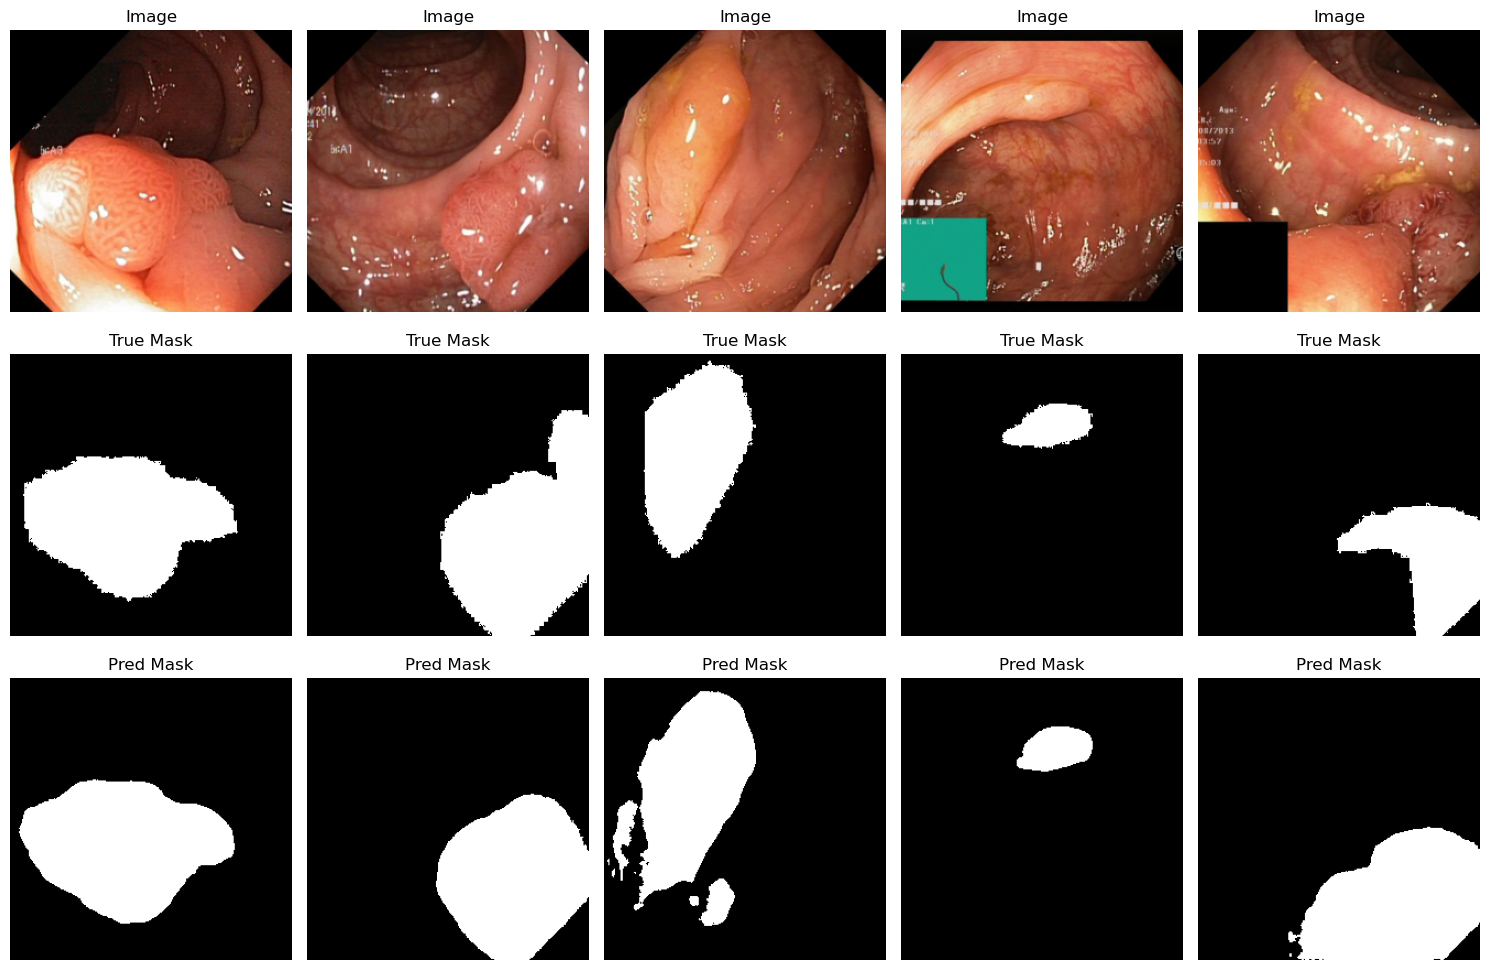

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",  
)
model.to(device)

criterion = criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

train(model, device, train_loader, val_loader, criterion, optimizer)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.77 PixelAcc = 0.84. Это очень хороший результат, но нужно учитывать что используется предобученная модель

### В качестве трансформенной модели выбран Mit_b0

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Epoch [1/10], Loss: 0.3995,  IoU: 0.4555, Pixel Acc: 0.7193
Val Loss: 0.4284, IoU: 0.4748, Pixel Acc: 0.8601


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Epoch [2/10], Loss: 0.3261,  IoU: 0.4479, Pixel Acc: 0.5677
Val Loss: 0.5502, IoU: 0.3680, Pixel Acc: 0.8891


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Epoch [3/10], Loss: 0.3237,  IoU: 0.4059, Pixel Acc: 0.5151
Val Loss: 0.3068, IoU: 0.4053, Pixel Acc: 0.4612


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:53<00:00,  1.89it/s]


Epoch [4/10], Loss: 0.3327,  IoU: 0.3665, Pixel Acc: 0.4566
Val Loss: 0.3320, IoU: 0.4386, Pixel Acc: 0.5639


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch [5/10], Loss: 0.3391,  IoU: 0.3413, Pixel Acc: 0.4321
Val Loss: 0.3309, IoU: 0.4028, Pixel Acc: 0.5161


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch [6/10], Loss: 0.3438,  IoU: 0.3253, Pixel Acc: 0.4161
Val Loss: 0.3446, IoU: 0.3439, Pixel Acc: 0.4307


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch [7/10], Loss: 0.3656,  IoU: 0.2786, Pixel Acc: 0.3507
Val Loss: 0.3688, IoU: 0.2045, Pixel Acc: 0.2331


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch [8/10], Loss: 0.3729,  IoU: 0.2407, Pixel Acc: 0.3021
Val Loss: 0.3859, IoU: 0.0630, Pixel Acc: 0.0648


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch [9/10], Loss: 0.3769,  IoU: 0.2124, Pixel Acc: 0.2587
Val Loss: 0.3880, IoU: 0.3347, Pixel Acc: 0.4764


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


Epoch [10/10], Loss: 0.3860,  IoU: 0.1843, Pixel Acc: 0.2206
Val Loss: 0.5020, IoU: 0.3162, Pixel Acc: 0.7466


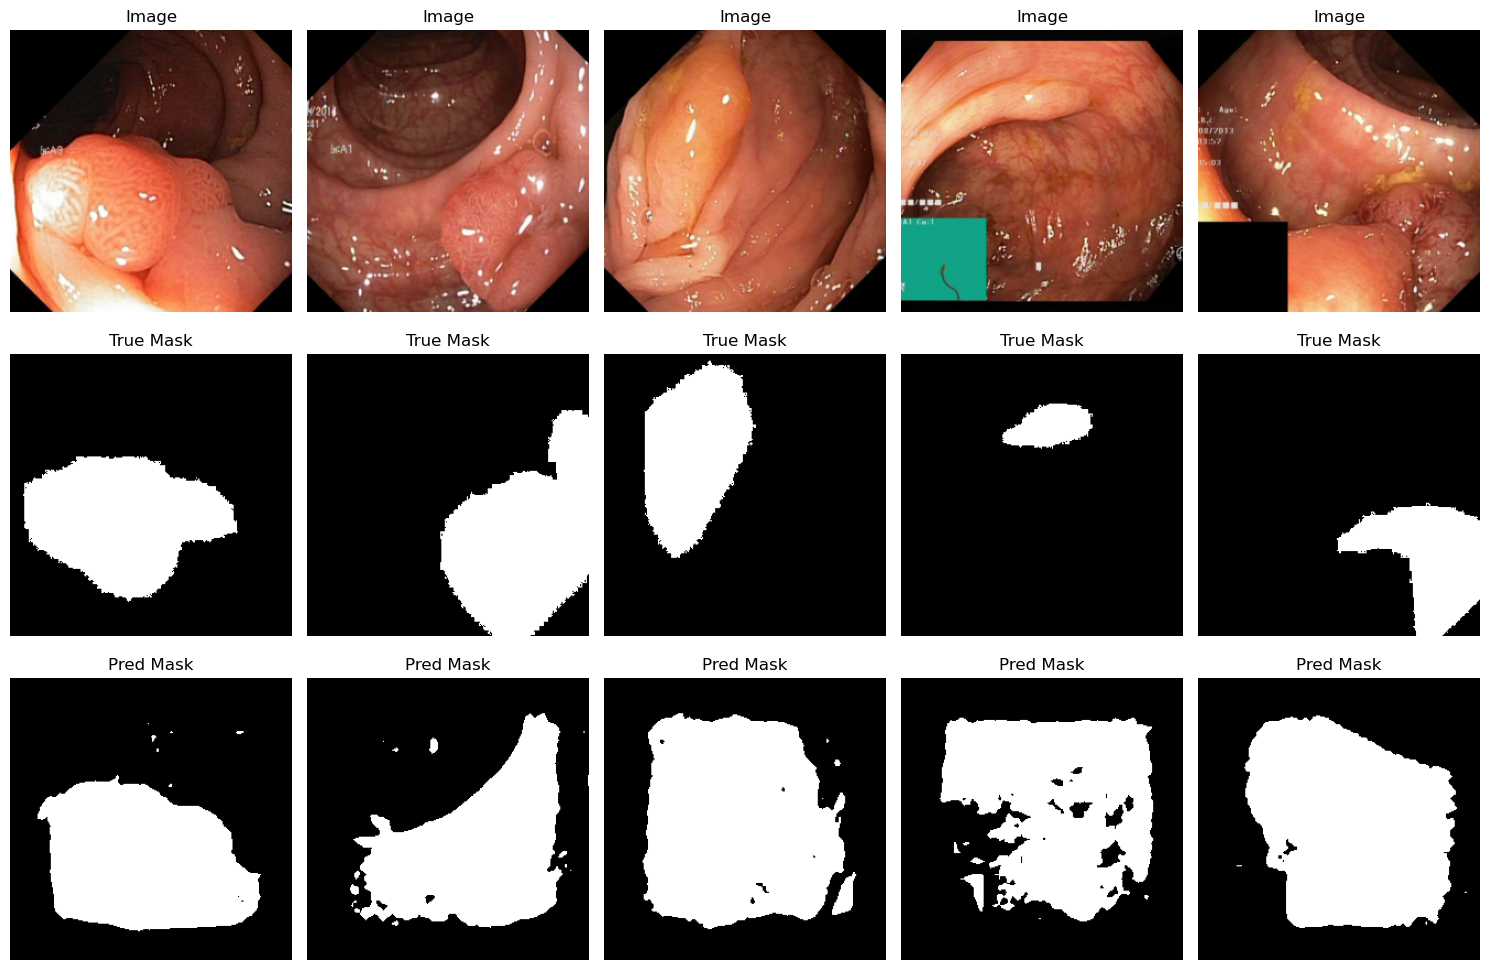

In [ ]:
model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",  # Бинарная сегментация
)
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

train(model, device, train_loader, val_loader, criterion, optimizer)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.31 PixelAcc = 0.74. Реузльтат чуть хуже, чем у свёрточной модели

## 3. Улучшение бейзлайна
### Формировние гипотез
- Используем более мощные модели, например Resnet50.
- Настроим вес положительного класса, чтобы сильнее наказывать за ошибку его сегментации
- Добавим планировщик

### Обучение свёрточной модели на улучшенном бейзлайне

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


Epoch [1/10], Loss: 0.4626,  IoU: 0.5811, Pixel Acc: 0.7423
Val Loss: 0.3267, IoU: 0.6927, Pixel Acc: 0.7983


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch [2/10], Loss: 0.2739,  IoU: 0.7448, Pixel Acc: 0.8747
Val Loss: 0.2570, IoU: 0.7343, Pixel Acc: 0.8439


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch [3/10], Loss: 0.1906,  IoU: 0.8240, Pixel Acc: 0.9183
Val Loss: 0.2595, IoU: 0.7329, Pixel Acc: 0.8897


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


Epoch [4/10], Loss: 0.1649,  IoU: 0.8359, Pixel Acc: 0.9221
Val Loss: 0.2121, IoU: 0.7605, Pixel Acc: 0.8766


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch [5/10], Loss: 0.1404,  IoU: 0.8520, Pixel Acc: 0.9315
Val Loss: 0.2305, IoU: 0.7427, Pixel Acc: 0.8098


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


Epoch [6/10], Loss: 0.1018,  IoU: 0.8934, Pixel Acc: 0.9542
Val Loss: 0.1997, IoU: 0.7825, Pixel Acc: 0.8725


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


Epoch [7/10], Loss: 0.0883,  IoU: 0.9053, Pixel Acc: 0.9592
Val Loss: 0.2318, IoU: 0.7638, Pixel Acc: 0.8407


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


Epoch [8/10], Loss: 0.0799,  IoU: 0.9072, Pixel Acc: 0.9588
Val Loss: 0.2141, IoU: 0.7712, Pixel Acc: 0.8678


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Epoch [9/10], Loss: 0.0672,  IoU: 0.9231, Pixel Acc: 0.9646
Val Loss: 0.1985, IoU: 0.7895, Pixel Acc: 0.8699


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch [10/10], Loss: 0.0577,  IoU: 0.9324, Pixel Acc: 0.9697
Val Loss: 0.2059, IoU: 0.7967, Pixel Acc: 0.8741


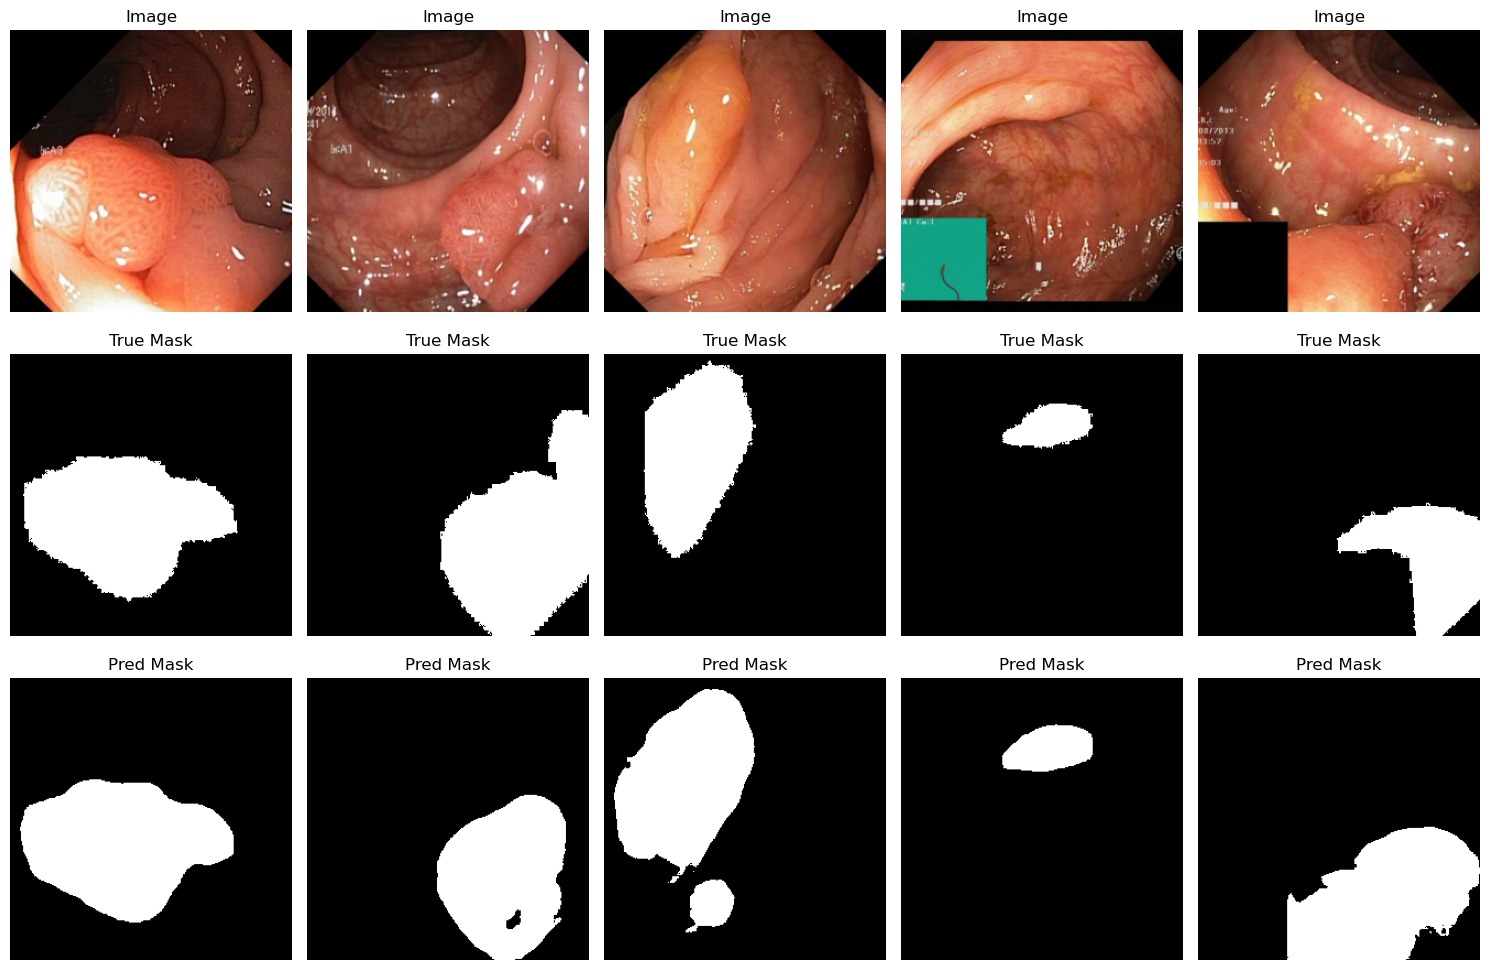

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    attention_type='scse'
)

model.to(device)

pos_weight = torch.tensor([2.0]).to(device)  
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

train(model, device, train_loader, val_loader, criterion, optimizer, scheduler)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.7967 PixelAcc = 0.87. Результат стал лучше

### Обучение трансформерной модели на улучшенном бейзлайне

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch [1/10], Loss: 0.8409,  IoU: 0.4180, Pixel Acc: 0.8100
Val Loss: 0.7867, IoU: 0.4968, Pixel Acc: 0.7490


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch [2/10], Loss: 0.8170,  IoU: 0.4001, Pixel Acc: 0.6619
Val Loss: 0.8019, IoU: 0.4350, Pixel Acc: 0.6493


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch [3/10], Loss: 0.8035,  IoU: 0.3853, Pixel Acc: 0.5474
Val Loss: 0.8155, IoU: 0.4353, Pixel Acc: 0.7543


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Epoch [4/10], Loss: 0.8030,  IoU: 0.3594, Pixel Acc: 0.4979
Val Loss: 0.8003, IoU: 0.1593, Pixel Acc: 0.1681


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch [5/10], Loss: 0.8038,  IoU: 0.3183, Pixel Acc: 0.4295
Val Loss: 0.7984, IoU: 0.3239, Pixel Acc: 0.3932


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch [6/10], Loss: 0.8036,  IoU: 0.3011, Pixel Acc: 0.3899
Val Loss: 0.8024, IoU: 0.1638, Pixel Acc: 0.1747


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch [7/10], Loss: 0.8037,  IoU: 0.2955, Pixel Acc: 0.3830
Val Loss: 0.9158, IoU: 0.3037, Pixel Acc: 0.8855


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Epoch [8/10], Loss: 0.8035,  IoU: 0.2856, Pixel Acc: 0.3674
Val Loss: 0.8050, IoU: 0.3397, Pixel Acc: 0.4594


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Epoch [9/10], Loss: 0.8036,  IoU: 0.2794, Pixel Acc: 0.3555
Val Loss: 0.8057, IoU: 0.3258, Pixel Acc: 0.4374


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Epoch [10/10], Loss: 0.8075,  IoU: 0.2507, Pixel Acc: 0.3232
Val Loss: 0.8083, IoU: 0.2493, Pixel Acc: 0.3040


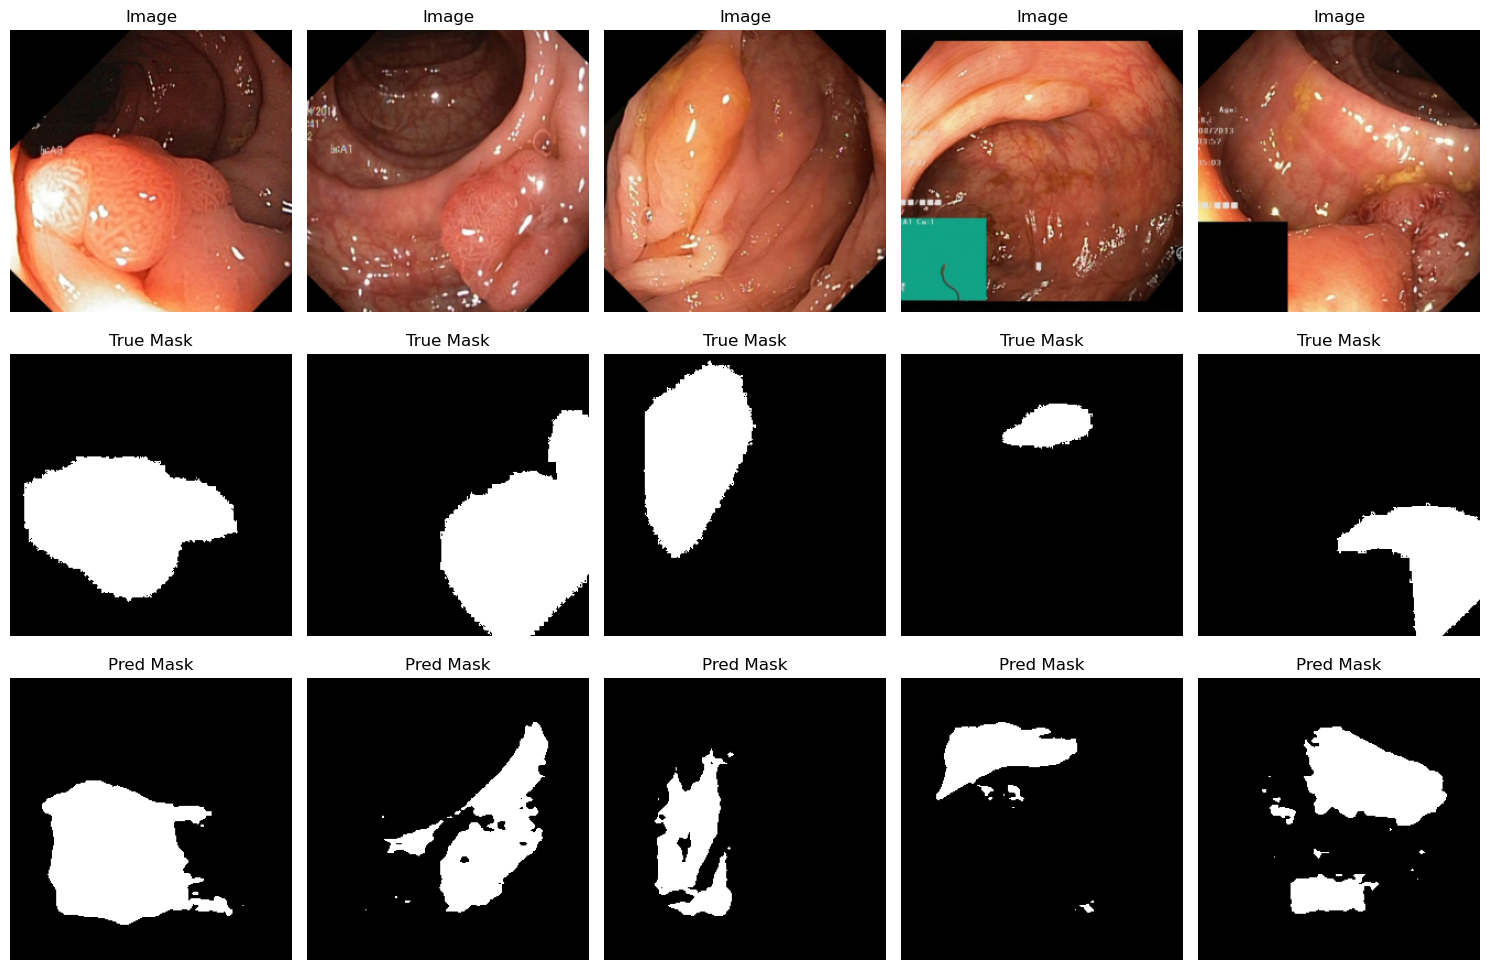

In [ ]:
model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",  # Бинарная сегментация
)
model.to(device)

pos_weight = torch.tensor([2.0]).to(device)  
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

train(model, device, train_loader, val_loader, criterion, optimizer, scheduler)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.3 PixelAcc = 0.3. Результат стал хуже

*Обучение моделей на разных бейзлайнах показало, что применённые улучшения помогли повысить точность сегментации только для свёрточны моделей, но трансформерные модели значительно деградировали*

## 4. Имплементация моделей

### Создание простой свёрточной сети

In [ ]:
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 32)
        self.encoder2 = conv_block(32, 64)
        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(64, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))

        b = self.bottleneck(self.pool(e2))

        d2 = self.upconv2(b)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return self.sigmoid(self.final_conv(d1))

### Создание своего трансформера

In [ ]:
class SegTransformer(nn.Module):
    def __init__(self,
                 img_size=256,
                 patch_size=16,  
                 in_ch=3,
                 embed_dim=128,
                 num_heads=4,
                 depth=4, 
                 num_classes=1):  
        super().__init__()
        
        assert img_size % patch_size == 0
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
      
        self.patch_embed = nn.Conv2d(in_ch, embed_dim, 
                                   kernel_size=patch_size, 
                                   stride=patch_size)
        
       
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        nn.init.normal_(self.pos_embed, std=0.01)
        
       
        self.transformer = nn.Sequential(*[
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim*2,
                dropout=0.0,
                activation='relu',
                batch_first=True
            ) for _ in range(depth)])
        
      
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
        
      
        self.size_adjust = nn.Upsample(size=(img_size, img_size), 
                                     mode='bilinear', 
                                     align_corners=False)
        
        nn.init.xavier_uniform_(self.decoder[-1].weight)
        nn.init.constant_(self.decoder[-1].bias, -2.0)

    def forward(self, x):
    
        x = self.patch_embed(x)  # [B, C, H/p, W/p]
        B, C, H, W = x.shape
        
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, C]
        x = x + self.pos_embed
        
        x = self.transformer(x)
        
        x = x.transpose(1, 2).reshape(B, C, H, W)
        
        x = self.decoder(x)  # [B, num_classes, H*2, W*2]
        
        x = self.size_adjust(x)  # [B, num_classes, img_size, img_size]
        
        return torch.sigmoid(x)

### Обучение свёрточной сети

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]


Epoch [1/10], Loss: 0.5592,  IoU: 0.2597, Pixel Acc: 0.4824
Val Loss: 0.5144, IoU: 0.2556, Pixel Acc: 0.4288


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


Epoch [2/10], Loss: 0.4994,  IoU: 0.2472, Pixel Acc: 0.3773
Val Loss: 0.4919, IoU: 0.2766, Pixel Acc: 0.4501


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch [3/10], Loss: 0.4690,  IoU: 0.2465, Pixel Acc: 0.3489
Val Loss: 0.4760, IoU: 0.2900, Pixel Acc: 0.4763


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch [4/10], Loss: 0.4465,  IoU: 0.2530, Pixel Acc: 0.3492
Val Loss: 0.4470, IoU: 0.2127, Pixel Acc: 0.2795


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch [5/10], Loss: 0.4295,  IoU: 0.2525, Pixel Acc: 0.3356
Val Loss: 0.4332, IoU: 0.1817, Pixel Acc: 0.2284


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch [6/10], Loss: 0.4172,  IoU: 0.2531, Pixel Acc: 0.3356
Val Loss: 0.4165, IoU: 0.2576, Pixel Acc: 0.3361


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch [7/10], Loss: 0.4041,  IoU: 0.2633, Pixel Acc: 0.3396
Val Loss: 0.4037, IoU: 0.2522, Pixel Acc: 0.3231


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch [8/10], Loss: 0.3957,  IoU: 0.2538, Pixel Acc: 0.3183
Val Loss: 0.4071, IoU: 0.3184, Pixel Acc: 0.4867


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch [9/10], Loss: 0.3917,  IoU: 0.2527, Pixel Acc: 0.3228
Val Loss: 0.4010, IoU: 0.2029, Pixel Acc: 0.2549


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch [10/10], Loss: 0.3835,  IoU: 0.2558, Pixel Acc: 0.3210
Val Loss: 0.3924, IoU: 0.2823, Pixel Acc: 0.3807


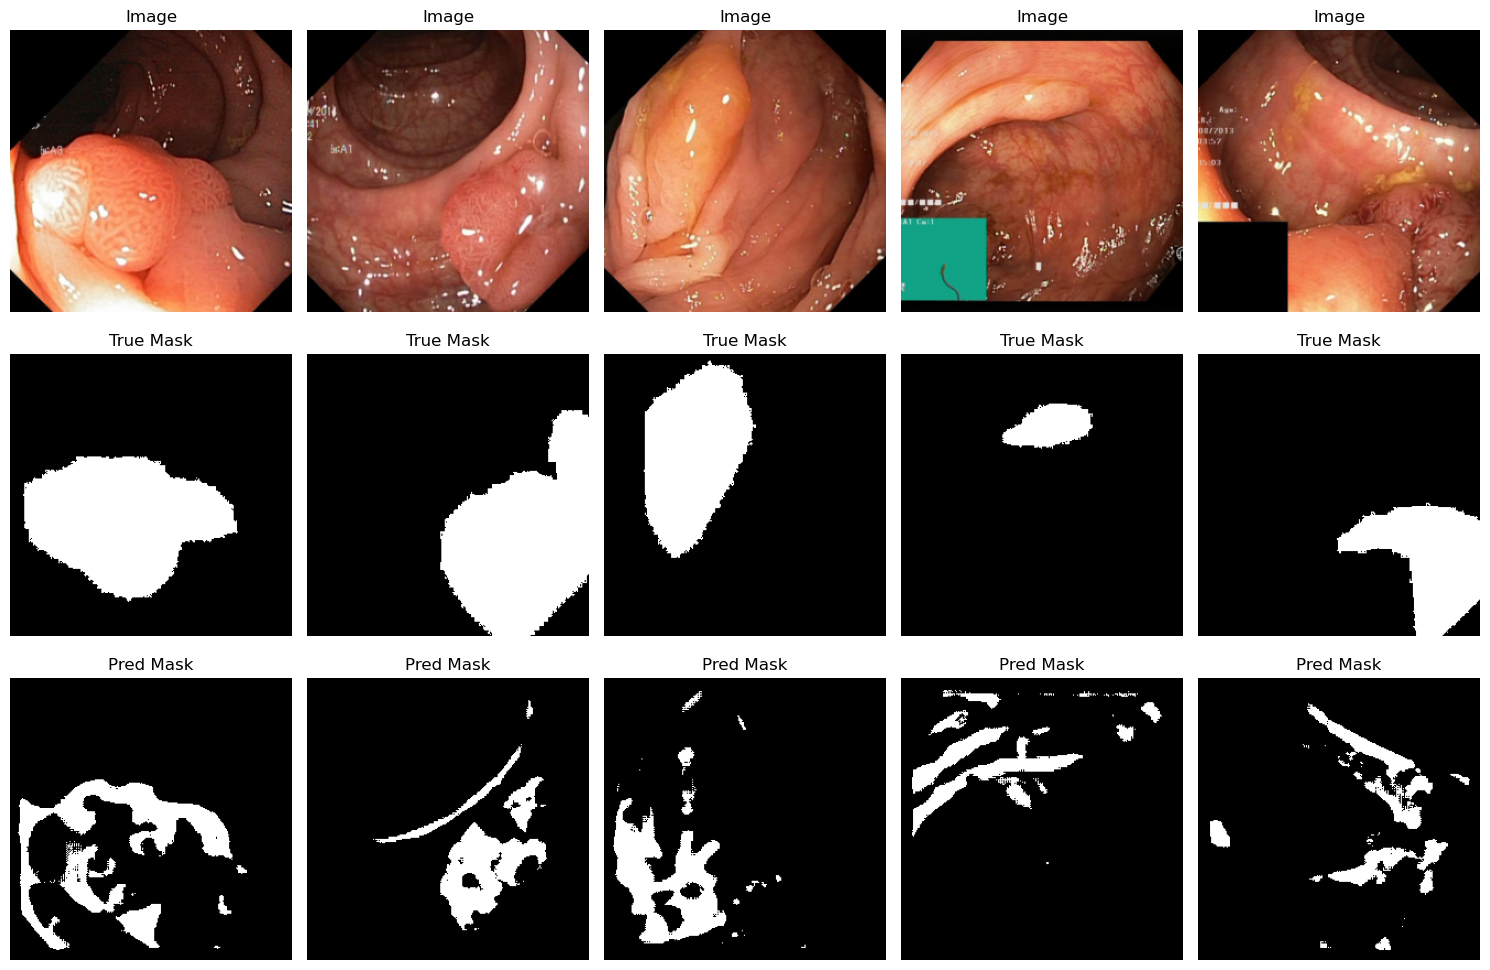

In [ ]:
model = SimpleUNet()
model.to(device)

criterion = criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

train(model, device, train_loader, val_loader, criterion, optimizer)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.28 PixelAcc = 0.38. Своя модель сегментирует хуже предобученной библиотечной

In [ ]:
model = SegTransformer()
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

train(model, device, train_loader, val_loader, criterion, optimizer)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


Epoch [1/10], Loss: 0.4324,  IoU: 0.0035, Pixel Acc: 0.0040
Val Loss: 0.4061, IoU: 0.0000, Pixel Acc: 0.0000


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch [2/10], Loss: 0.4083,  IoU: 0.0059, Pixel Acc: 0.0075
Val Loss: 0.4081, IoU: 0.2033, Pixel Acc: 0.2505


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch [3/10], Loss: 0.4026,  IoU: 0.0390, Pixel Acc: 0.0439
Val Loss: 0.3839, IoU: 0.0574, Pixel Acc: 0.0593


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


Epoch [4/10], Loss: 0.3992,  IoU: 0.0545, Pixel Acc: 0.0640
Val Loss: 0.3924, IoU: 0.1514, Pixel Acc: 0.1745


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


Epoch [5/10], Loss: 0.3931,  IoU: 0.0789, Pixel Acc: 0.0880
Val Loss: 0.3946, IoU: 0.0472, Pixel Acc: 0.0496


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch [6/10], Loss: 0.3894,  IoU: 0.0907, Pixel Acc: 0.1094
Val Loss: 0.3701, IoU: 0.1309, Pixel Acc: 0.1436


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


Epoch [7/10], Loss: 0.3862,  IoU: 0.1256, Pixel Acc: 0.1513
Val Loss: 0.3864, IoU: 0.2215, Pixel Acc: 0.2792


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch [8/10], Loss: 0.3849,  IoU: 0.1218, Pixel Acc: 0.1418
Val Loss: 0.3820, IoU: 0.0170, Pixel Acc: 0.0173


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


Epoch [9/10], Loss: 0.3794,  IoU: 0.1458, Pixel Acc: 0.1740
Val Loss: 0.3596, IoU: 0.2520, Pixel Acc: 0.3058


Epoch 10/10:  54%|█████████████████████                  | 54/100 [00:06<00:05,  7.97it/s]

Итоговый IoU=0.25 PixelAcc = 0.3. 

### Сравнение с п.2
При сравнении становится понятно, что библиотечные предобученные модели имеют гораздо лучшую точность по сравнению с моими моделями

### Применение улучшенного бейзлайна на собственной модели

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


Epoch [1/10], Loss: 0.8910,  IoU: 0.2626, Pixel Acc: 0.5132
Val Loss: 0.8782, IoU: 0.2719, Pixel Acc: 0.4977


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch [2/10], Loss: 0.8706,  IoU: 0.2775, Pixel Acc: 0.4758
Val Loss: 0.8584, IoU: 0.2364, Pixel Acc: 0.3301


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch [3/10], Loss: 0.8583,  IoU: 0.2721, Pixel Acc: 0.4239
Val Loss: 0.8650, IoU: 0.2958, Pixel Acc: 0.5005


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch [4/10], Loss: 0.8484,  IoU: 0.2865, Pixel Acc: 0.4268
Val Loss: 0.8427, IoU: 0.1632, Pixel Acc: 0.1862


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch [5/10], Loss: 0.8416,  IoU: 0.2814, Pixel Acc: 0.3949
Val Loss: 0.8443, IoU: 0.2991, Pixel Acc: 0.4586


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch [6/10], Loss: 0.8362,  IoU: 0.2810, Pixel Acc: 0.3926
Val Loss: 0.8384, IoU: 0.2582, Pixel Acc: 0.3454


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


Epoch [7/10], Loss: 0.8305,  IoU: 0.2863, Pixel Acc: 0.3962
Val Loss: 0.8354, IoU: 0.2757, Pixel Acc: 0.3910


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch [8/10], Loss: 0.8267,  IoU: 0.2834, Pixel Acc: 0.3803
Val Loss: 0.8276, IoU: 0.2918, Pixel Acc: 0.3988


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


Epoch [9/10], Loss: 0.8222,  IoU: 0.2930, Pixel Acc: 0.3893
Val Loss: 0.8248, IoU: 0.3154, Pixel Acc: 0.4542


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch [10/10], Loss: 0.8197,  IoU: 0.3010, Pixel Acc: 0.3968
Val Loss: 0.8202, IoU: 0.2752, Pixel Acc: 0.3472


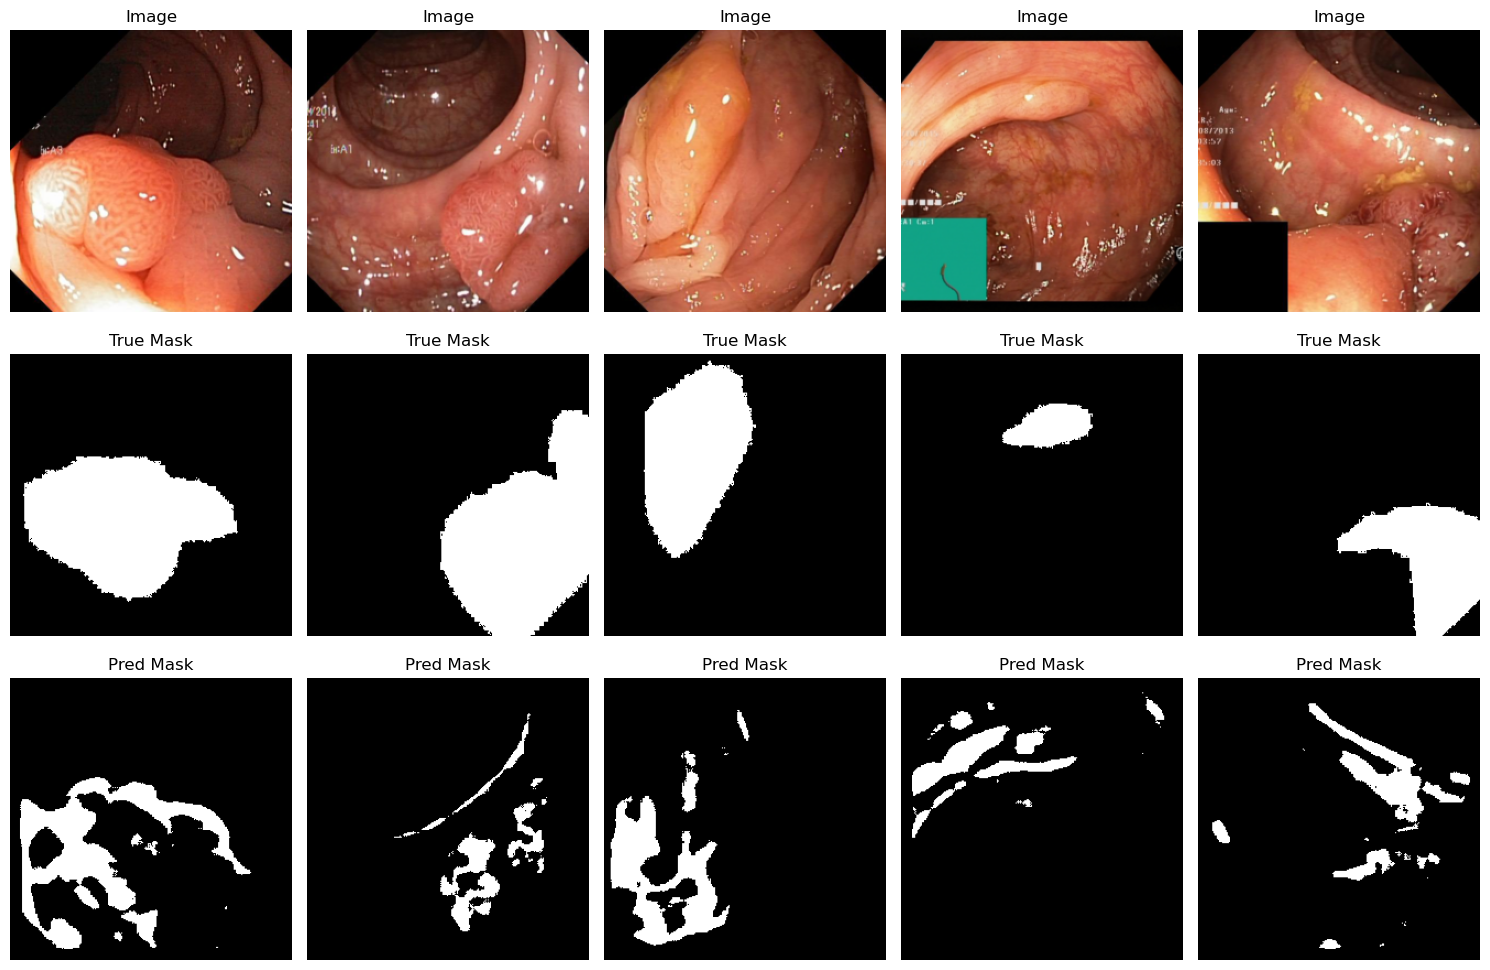

In [ ]:
model = SimpleUNet()
model.to(device)

pos_weight = torch.tensor([2.0]).to(device)  
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

train(model, device, train_loader, val_loader, criterion, optimizer, scheduler)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.28 PixelAcc = 0.34. Улучшение бейзлайна не помогло

Epoch 1/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch [1/10], Loss: 0.4304,  IoU: 0.0250, Pixel Acc: 0.0370
Val Loss: 0.4165, IoU: 0.0000, Pixel Acc: 0.0000


Epoch 2/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch [2/10], Loss: 0.4232,  IoU: 0.0055, Pixel Acc: 0.0063
Val Loss: 0.4004, IoU: 0.0015, Pixel Acc: 0.0015


Epoch 3/10: 100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch [3/10], Loss: 0.4114,  IoU: 0.0025, Pixel Acc: 0.0029
Val Loss: 0.3861, IoU: 0.0001, Pixel Acc: 0.0001


Epoch 4/10: 100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch [4/10], Loss: 0.4063,  IoU: 0.0170, Pixel Acc: 0.0207
Val Loss: 0.3791, IoU: 0.0037, Pixel Acc: 0.0037


Epoch 5/10: 100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch [5/10], Loss: 0.3925,  IoU: 0.0362, Pixel Acc: 0.0513
Val Loss: 0.3833, IoU: 0.0001, Pixel Acc: 0.0001


Epoch 6/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch [6/10], Loss: 0.3866,  IoU: 0.0752, Pixel Acc: 0.0936
Val Loss: 0.3973, IoU: 0.0307, Pixel Acc: 0.0315


Epoch 7/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch [7/10], Loss: 0.3890,  IoU: 0.0473, Pixel Acc: 0.0560
Val Loss: 0.3709, IoU: 0.0109, Pixel Acc: 0.0110


Epoch 8/10: 100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch [8/10], Loss: 0.3765,  IoU: 0.1167, Pixel Acc: 0.1392
Val Loss: 0.3625, IoU: 0.0460, Pixel Acc: 0.0478


Epoch 9/10: 100%|███████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch [9/10], Loss: 0.3736,  IoU: 0.1565, Pixel Acc: 0.1924
Val Loss: 0.3728, IoU: 0.0164, Pixel Acc: 0.0166


Epoch 10/10: 100%|██████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


Epoch [10/10], Loss: 0.3737,  IoU: 0.1245, Pixel Acc: 0.1497
Val Loss: 0.3665, IoU: 0.1792, Pixel Acc: 0.2065


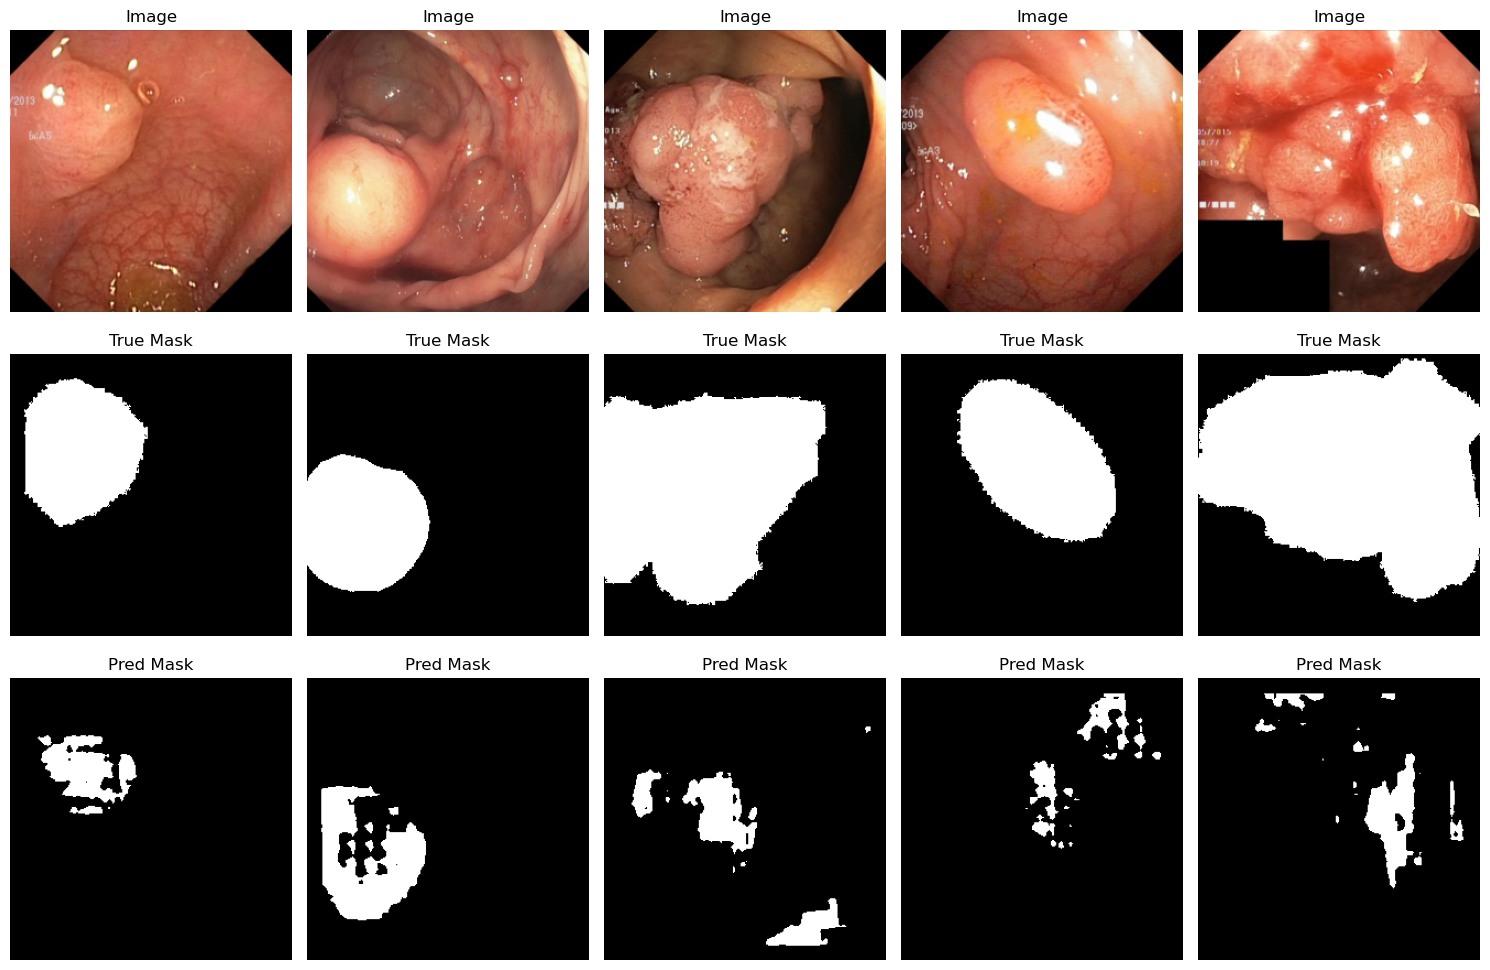

In [ ]:
model = SegTransformer()
model.to(device)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

train(model, device, train_loader, val_loader, criterion, optimizer, scheduler)

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()


plot_examples(images, masks, preds)

Итоговый IoU=0.18 PixelAcc = 0.20. Улучшение бейзлайна не помогло

## Результаты

Сравним результаты обучения моделей

Модель|Метрики обычного бейзлайна| Метрики улучшенного бейзлайна   |
|---|---|---------------------------------|
|Свёрточный классификатор|IoU = 0.77 Acc = 0.84| IoU = 0.79 Acc = 0.87|
|Трансформерный классификатор|IoU = 0.32 Acc = 0.74 | IoU = 0.3 Acc = 0.3 |
|Мой свёрточный классификатор|IoU = 0.28 Acc = 0.34 | IoU = 0.28 Acc = 0.34  |
|Мой трансформерный классификатор|IoU = 0.25 Acc = 0.3 | IoU = 0.18 Acc = 0.2 |

При разных бейзлайнах библиотечные реализации моделей оказывались значительно лучше моих имплементаций